In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimHandlerFtr
from lib.geo import center_track_pos_and_time_based_on_data

In [2]:
# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')


def get_event_data(event_index):
    meta, pulses = sim_handler.get_event_data(event_index)
    #print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

    # Get dom locations, first hit times, and total charges (for each dom).
    event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

    return (event_data[['x', 'y','z','time']].to_numpy(), 
            meta[['muon_energy_at_detector', 'q_tot', 'muon_zenith', 'muon_azimuth', 'muon_time',
                  'muon_pos_x', 'muon_pos_y', 'muon_pos_z', 'spline_mpe_zenith',
                  'spline_mpe_azimuth', 'spline_mpe_time', 'spline_mpe_pos_x',
                  'spline_mpe_pos_y', 'spline_mpe_pos_z']].to_numpy())

In [3]:
meta, pulses = sim_handler.get_event_data(0)
print(meta)

event_id                   2.121703e+09
idx_start                  0.000000e+00
idx_end                    4.600000e+01
n_channel_HLC              2.100000e+01
neutrino_energy            4.722192e+04
muon_energy                3.391497e+04
muon_energy_at_detector    2.139244e+03
muon_energy_lost           8.823812e+02
q_tot                      4.357500e+01
n_channel                  2.900000e+01
muon_zenith                2.201092e+00
muon_azimuth               4.044857e+00
muon_time                  3.002587e+03
muon_pos_x                -1.277511e+03
muon_pos_y                -1.390396e+03
muon_pos_z                -1.675980e+03
spline_mpe_zenith          2.224013e+00
spline_mpe_azimuth         4.035248e+00
spline_mpe_time            1.088498e+04
spline_mpe_pos_x          -9.655990e+01
spline_mpe_pos_y           1.078559e+02
spline_mpe_pos_z          -2.819733e+02
Name: 0, dtype: float64


In [4]:
_, meta = get_event_data(0)
print(meta)

[ 2.13924365e+03  4.35750000e+01  2.20109211e+00  4.04485650e+00
  3.00258667e+03 -1.27751129e+03 -1.39039565e+03 -1.67598025e+03
  2.22401345e+00  4.03524788e+00  1.08849820e+04 -9.65598967e+01
  1.07855873e+02 -2.81973256e+02]


In [5]:
pulse_data = []
meta_data = []
n_doms = []

for i in range(1000):
    ev, meta = get_event_data(i)
    pulse_data.append(ev)
    meta_data.append(meta)
    n_doms.append(ev.shape[0])

In [6]:
print(meta_data[1])

[ 2.01925366e+03  2.74200001e+02  2.28442419e+00  3.92640830e+00
  9.63442488e+03 -5.75877731e+01  1.04949606e+02 -4.59586996e+02
  2.29277311e+00  3.80837905e+00  9.91118734e+03 -1.49526274e+01
  1.51046642e+02 -4.04819476e+02]


346 13


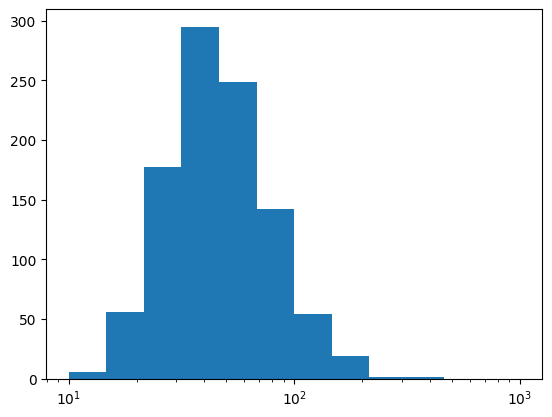

[  10.           12.58925412   15.84893192   19.95262315   25.11886432
   31.6227766    39.81071706   50.11872336   63.09573445   79.43282347
  100.          125.89254118  158.48931925  199.5262315   251.18864315
  316.22776602  398.10717055  501.18723363  630.95734448  794.32823472
 1000.        ]
[  6  56 177 295 249 142  54  19   1   1   0   0]
1000


In [7]:
print(max(n_doms), min(n_doms))

plt.hist(n_doms, bins=np.logspace(1, 3, 13))
plt.xscale('log')
plt.show()

print(np.logspace(1, 3, 21))
cts, bins = np.histogram(n_doms, bins=np.logspace(1, 3, 13))
print(cts)
print(sum(cts))

In [8]:
print(bins.astype(int))

[  10   14   21   31   46   68  100  146  215  316  464  681 1000]


In [9]:
pulse_data_tf = tf.ragged.constant(pulse_data, ragged_rank=1, dtype=tf.float32)

In [10]:
meta_data_tf = tf.constant(meta_data, dtype=tf.float32)

In [11]:
ds = tf.data.Dataset.from_tensor_slices((pulse_data_tf, meta_data_tf))
ds = ds.map(lambda x, y: (x, y))

_element_length_funct = lambda x, y: tf.shape(x)[0]
ds = ds.bucket_by_sequence_length(
            element_length_func = _element_length_funct,
            bucket_boundaries = np.logspace(1, 3, 13).astype(int).tolist(),
            bucket_batch_sizes = [128]*14,
            drop_remainder = False,
            pad_to_bucket_boundary=True
        )

In [12]:
for x, y in ds:
    print(x.shape, y.shape)

(128, 45, 4) (128, 14)
(128, 67, 4) (128, 14)
(128, 30, 4) (128, 14)
(128, 99, 4) (128, 14)
(128, 45, 4) (128, 14)
(2, 13, 4) (2, 14)
(50, 20, 4) (50, 14)
(41, 30, 4) (41, 14)
(45, 45, 4) (45, 14)
(123, 67, 4) (123, 14)
(24, 99, 4) (24, 14)
(53, 145, 4) (53, 14)
(20, 214, 4) (20, 14)
(1, 315, 4) (1, 14)
(1, 463, 4) (1, 14)


2024-06-05 18:27:45.833676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for x, y in ds:
    if x.shape[0]==128:
        break

In [14]:
for d in x:
    print(d.shape)

(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)
(45, 4)


In [15]:
from lib.simdata_i3 import I3SimBatchHandler

In [16]:
batch_maker = I3SimBatchHandler(sim_handler)

In [17]:
batch_iter = batch_maker.get_batch_iterator()

In [18]:
a,b = batch_iter.next()

In [19]:
ev_idx = 0

In [20]:
fitting_event_data = jnp.array(a[ev_idx])
print(fitting_event_data.shape)

muon_truth = b[ev_idx, 2:8]
track_src = jnp.array(muon_truth[:2])
track_time = jnp.array(muon_truth[2])
track_pos = jnp.array(muon_truth[3:])
event_data = pd.DataFrame({'time': fitting_event_data[:, 3],
                           'charge': fitting_event_data[:, 4]
})

centered_track_pos, centered_track_time = \
    center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)

fitting_event_data = fitting_event_data[:, :4]
print(jnp.rad2deg(track_src))
print(track_time)
print(track_pos)

(57, 5)
[115.76073569 106.1228205 ]
4656.809303265065
[  -65.71173861  1800.82339061 -1057.15159503]


In [21]:
print(centered_track_pos)
print(centered_track_time)

[ 407.88112043  162.47186024 -234.15666758]
10973.254424115226


In [22]:
fitting_event_data = fitting_event_data[:-12]

In [23]:
print(fitting_event_data)

[[ 5.0043e+02 -5.8450e+01 -1.1089e+02  1.2156e+04]
 [ 5.0043e+02 -5.8450e+01 -1.2791e+02  1.2000e+04]
 [ 5.0043e+02 -5.8450e+01 -1.4493e+02  1.2414e+04]
 [ 5.0043e+02 -5.8450e+01 -1.6195e+02  1.2293e+04]
 [ 4.1181e+02  1.3000e+01 -1.4505e+02  1.1671e+04]
 [ 4.1181e+02  1.3000e+01 -1.6207e+02  1.1709e+04]
 [ 4.1181e+02  1.3000e+01 -1.7910e+02  1.2425e+04]
 [ 4.1181e+02  1.3000e+01 -1.9612e+02  1.1719e+04]
 [ 5.4407e+02  5.5890e+01 -1.2698e+02  1.2071e+04]
 [ 5.4407e+02  5.5890e+01 -1.9507e+02  1.2556e+04]
 [ 1.9503e+02  1.2559e+02 -3.8324e+02  1.3188e+04]
 [ 4.7205e+02  1.2790e+02 -1.4251e+02  1.2419e+04]
 [ 4.7205e+02  1.2790e+02 -1.5953e+02  1.1791e+04]
 [ 4.7205e+02  1.2790e+02 -1.9358e+02  1.1449e+04]
 [ 4.7205e+02  1.2790e+02 -2.1060e+02  1.2026e+04]
 [ 4.7205e+02  1.2790e+02 -2.2762e+02  1.1971e+04]
 [ 4.7205e+02  1.2790e+02 -2.4464e+02  1.1372e+04]
 [ 1.3203e+02  2.0298e+02 -3.8234e+02  1.2859e+04]
 [ 2.5731e+02  2.1166e+02 -3.2959e+02  1.2326e+04]
 [ 3.8235e+02  2.3890e+02 -1.82

In [24]:
from lib.network import get_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad_profile
from likelihood_spe import get_neg_c_triple_gamma_llh

In [25]:
# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

In [26]:
obj_fn, obj_grad = get_llh_and_grad_fs_for_iminuit_migrad(eval_network_doms_and_track)

# put the thing below into a for loop if you want to reconstruct many events (without jit-recompiling everything)
f_prime = lambda x: obj_fn(x, centered_track_time, fitting_event_data)
grad_prime = lambda x: obj_grad(x, centered_track_time, fitting_event_data)

In [27]:
from iminuit import Minuit

In [28]:
x0 = jnp.concatenate([track_src, centered_track_pos])
m = Minuit(f_prime, x0, grad=grad_prime)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 1
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 573.3                      │        Nfcn = 113, Ngrad = 12        │
│ EDM = 3.28e-05 (Goal: 0.0001)    │            time = 4.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   2.028   │   0.004   │            │            │    0    │ 3.14159 │       │
│ 1 │ x1   │   1.841   │   0.005   │            │            │    0    │ 6.28319 │       │
│ 2 │ x2   │   404.2   │    1.4    │            │            │  -500   │   500   │       │
│ 3 │ x3   │   161.6   │    1.2    │            │            │  -500   │   500   │       │
│ 4 │ x4   │  -234.7   │    0.4    │            │            │  -500   │   500   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │  1.44e-05  0.005e-3  0.538e-3 -3.820e-3 -0.641e-3 │
│ x1 │  0.005e-3  2.78e-05  5.948e-3 -0.480e-3  0.460e-3 │
│ x2 │  0.538e-3  5.948e-3      1.99       0.4      0.07 │
│ x3 │ -3.820e-3 -0.480e-3       0.4      1.53      0.01 │
│ x4 │ -0.641e-3  0.460e-3      0.07      0.01     0.127 │
└────┴───────────────────────────────────────────────────┘

In [29]:
print("... solution found.")
print(f"-2*logl={m.fval:.3f}")
print(f"zenith={m.values[0]:.3f}rad")
print(f"azimuth={m.values[1]:.3f}rad")
print(f"x={m.values[2]:.3f}m")
print(f"y={m.values[3]:.3f}m")
print(f"z={m.values[4]:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=573.346
zenith=2.028rad
azimuth=1.841rad
x=404.210m
y=161.569m
z=-234.690m
at fix time t=10973.254ns


In [30]:
print(track_src)

[2.02040598 1.85219263]


In [31]:
print(f_prime(x0))

578.4324327091223


In [39]:
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)
scale = 10.0

@jax.jit
def neg_llh_5D(x, track_time, data):
    return neg_llh(x[:2], x[2:]*scale, track_time, data)

@jax.jit
def minimize_bfgs(x0, track_time, data):
    result = optimize.minimize(neg_llh_5D,
                                x0,
                                args=(track_time, data),
                                method="BFGS", 
                                options={'maxiter':50, 'gtol':1.e-3})
    
    return result.fun, result.x

x0 = jnp.concatenate([track_src, centered_track_pos/scale])
best_logl, best_x = minimize_bfgs(x0, centered_track_time, fitting_event_data)

print("... solution found.")
print(f"-2*logl={best_logl:.3f}")
print(f"zenith={best_x[0]:.3f}rad")
print(f"azimuth={best_x[1]:.3f}rad")
print(f"x={best_x[2]*scale:.3f}m")
print(f"y={best_x[3]*scale:.3f}m")
print(f"z={best_x[4]*scale:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=572.894
zenith=2.022rad
azimuth=1.840rad
x=403.841m
y=160.319m
z=-235.551m
at fix time t=10973.254ns


In [40]:
%timeit minimize_bfgs(x0, centered_track_time, fitting_event_data)

58.9 ms ± 40.8 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
@jax.jit
def minimize_bfgs(x0, track_time, data):
    result = optimize.minimize(neg_llh_5D,
                                x0,
                                args=(track_time, data),
                                method="BFGS", 
                                options={'maxiter':50, 'gtol':1.e-3})
    
    return result

In [35]:
result = minimize_bfgs(x0, centered_track_time, fitting_event_data)

In [36]:
print(result)

OptimizeResults(x=Array([ 2.0198695 ,  1.84010394,  4.03617128,  1.59866496, -2.35893489],      dtype=float64), success=Array(True, dtype=bool), status=Array(0, dtype=int64, weak_type=True), fun=Array(572.56498299, dtype=float64), jac=Array([-3.44216129e-04, -4.63336573e-05, -6.42294918e-05,  5.92673834e-05,
        3.98623429e-04], dtype=float64), hess_inv=Array([[ 2.98532616e-05,  6.09268427e-06,  1.69518371e-05,
         1.08225752e-05,  2.19924615e-05],
       [ 6.09268427e-06,  3.00892198e-05,  6.57211604e-05,
        -2.38957774e-06,  3.22434643e-06],
       [ 1.69518371e-05,  6.57211604e-05,  2.16860006e-04,
         4.96030210e-05,  1.00028137e-05],
       [ 1.08225752e-05, -2.38957774e-06,  4.96030210e-05,
         1.44765612e-04,  3.16079189e-05],
       [ 2.19924615e-05,  3.22434643e-06,  1.00028137e-05,
         3.16079189e-05,  4.10261027e-05]], dtype=float64), nfev=Array(30, dtype=int64, weak_type=True), njev=Array(30, dtype=int64, weak_type=True), nit=Array(21, dtype=int

In [62]:
%timeit minimize_bfgs(x0, centered_track_time, fitting_event_data)

68.1 ms ± 138 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
